In [1]:
import math
import cv2
import numpy as np
import Tien_xu_ly

# Định nghĩa các hằng số dùng cho ngưỡng thích nghi


ADAPTIVE_THRESH_BLOCK_SIZE: Đây là kích thước của khu vực lân cận sẽ được sử dụng để tính ngưỡng cục bộ. Trong trường hợp này, kích thước của khu vực là 19x19 pixel.

Ngưỡng cục bộ (adaptive threshold) là một kỹ thuật được sử dụng để chuyển đổi ảnh xám (grayscale) thành ảnh nhị phân (binary image) dựa trên một ngưỡng được tính toán dựa trên các giá trị pixel trong một khu vực lân cận xung quanh từng điểm ảnh

In [2]:

ADAPTIVE_THRESH_BLOCK_SIZE = 19 



ADAPTIVE_THRESH_WEIGHT: Đây là một hệ số được sử dụng trong phương pháp tính toán ngưỡng cục bộ. Nó ảnh hưởng đến mức độ làm mờ và làm sắc nét ảnh kết quả. Trong trường hợp này, giá trị của hệ số là 9.

In [3]:
ADAPTIVE_THRESH_WEIGHT = 9

In [4]:
# Biến đếm số lượng biển số xe
n = 1  

# Định nghĩa các hằng số dùng cho lọc kí tự
Min_char = 0.01
Max_char = 0.09

Đọc ảnh đầu vào và resize ảnh về kích thước 1920x1080

In [5]:
img = cv2.imread("data/image/1.jpg")
img = cv2.resize(img, dsize=(1920, 1080))

tăng độ tương phản

In [6]:

anh_xam, anh_nhi_phan = Tien_xu_ly.tienxuly(img)


In [7]:
#Trong xử lý ảnh, việc tạo ảnh biên bằng phương pháp Canny (Canny edge detection) giúp phát hiện và nhận dạng các ranh giới hoặc biên của các đối tượng trong ảnh. Điều này có thể hữu ích trong nhiều ứng dụng, bao gồm nhận dạng vật thể, phân loại và phát hiện các đặc điểm quan trọng trong hình ảnh.
canny_image = cv2.Canny(anh_nhi_phan, 250, 255)  # Tạo ảnh biên bằng phương pháp Canny
kernel = np.ones((3, 3), np.uint8)  # Tạo kernel cho phép dãn (Tạo ra một kernel có kích thước 3x3 với tất cả các giá trị là 1. Kernel này được sử dụng để xác định cách phép dãn sẽ được áp dụng cho ảnh.)
dilated_image = cv2.dilate(canny_image, kernel, iterations=1) 
# Dãn ảnh (Áp dụng phép dãn cho ảnh canny_image bằng cách sử dụng kernel được chỉ định. Tham số iterations=1 xác định số lần lặp của quá trình dãn, trong trường hợp này là một lần.)
# cv2.imshow("dilated_image",dilated_image)


In [8]:
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Sắp xếp và lấy 10 đường viền có diện tích lớn nhất
# cv2.drawContours(img, contours, -1, (255, 0, 255), 3) # Vẽ tất cả các đường viền trong hình lớn

In [9]:
import cv2
import numpy as np
import math

# Giả sử bạn đã có img, contours, anh_xam và anh_nhi_phan từ trước
def tachanh(url) :
    img = cv2.imread(url)
    img = cv2.resize(img, dsize=(1920, 1080))
    anh_xam, anh_nhi_phan = Tien_xu_ly.tienxuly(img)
    #Trong xử lý ảnh, việc tạo ảnh biên bằng phương pháp Canny (Canny edge detection) giúp phát hiện và nhận dạng các ranh giới hoặc biên của các đối tượng trong ảnh. Điều này có thể hữu ích trong nhiều ứng dụng, bao gồm nhận dạng vật thể, phân loại và phát hiện các đặc điểm quan trọng trong hình ảnh.
    canny_image = cv2.Canny(anh_nhi_phan, 250, 255)  # Tạo ảnh biên bằng phương pháp Canny
    kernel = np.ones((3, 3), np.uint8)  # Tạo kernel cho phép dãn (Tạo ra một kernel có kích thước 3x3 với tất cả các giá trị là 1. Kernel này được sử dụng để xác định cách phép dãn sẽ được áp dụng cho ảnh.)
    dilated_image = cv2.dilate(canny_image, kernel, iterations=1) 
    # Dãn ảnh (Áp dụng phép dãn cho ảnh canny_image bằng cách sử dụng kernel được chỉ định. Tham số iterations=1 xác định số lần lặp của quá trình dãn, trong trường hợp này là một lần.)
    # cv2.imshow("dilated_image",dilated_image)
    contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Sắp xếp và lấy 10 đường viền có diện tích lớn nhất
    screenCnt = []  # Danh sách các đường viền của biển số xe
    for c in contours:
        peri = cv2.arcLength(c, True)  # Tính chu vi của đường viền
        approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Làm xấp xỉ đa giác, chỉ giữ đường viền có 4 cạnh
        [x, y, w, h] = cv2.boundingRect(approx.copy())  # Tạo hình chữ nhật bao quanh đa giác
        ratio = w / h  # Tính tỷ lệ chiều rộng / chiều cao
        if len(approx) == 4:  # Nếu đường viền có 4 cạnh
            screenCnt.append(approx)  # Thêm vào danh sách các đường viền của biển số xe
            cv2.putText(img, str(len(approx.copy())), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)
    if not screenCnt:  # Nếu không có biển số nào được phát hiện
        detected = 0
        print("No plate detected")
    else:
        detected = 1

    if detected == 1:
        for screenCnt in screenCnt:
            cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)  # Khoanh vùng biển số xe
            # cv2.imshow("Contours", img)

            ############## Tìm góc của biển số xe #####################
            (x1, y1) = screenCnt[0, 0]
            (x2, y2) = screenCnt[1, 0]
            (x3, y3) = screenCnt[2, 0]
            (x4, y4) = screenCnt[3, 0]
            array = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
            sorted_array = sorted(array, reverse=True, key=lambda x: x[1])
            (x1, y1) = sorted_array[0]
            (x2, y2) = sorted_array[1]
            doi = abs(y1 - y2)  # Tính độ chênh lệch y
            ke = abs(x1 - x2)  # Tính độ chênh lệch x
            angle = math.atan(doi / ke) * (180.0 / math.pi)  # Tính góc nghiêng của biển số

            ####################################

            ########## Cắt biển số và căn chỉnh đúng góc ################
            mask = np.zeros(anh_xam.shape, np.uint8)  # Tạo mặt nạ đen với kích thước bằng ảnh gốc
            new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1)  # Vẽ đường viền biển số lên mặt nạ
            # cv2.imshow("Mask", new_image)

            # Cắt ảnh
            (x, y) = np.where(mask == 255)  # Lấy tọa độ của các pixel nằm trong biển số
            print(x,y)
            (topx, topy) = (np.min(x), np.min(y))  # Tọa độ trên cùng của biển số
            (bottomx, bottomy) = (np.max(x), np.max(y))  # Tọa độ dưới cùng của biển số

            roi = img[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh chứa biển số
            imgThresh = anh_nhi_phan[topx:bottomx, topy:bottomy]  # Cắt vùng ảnh ngưỡng chứa biển số
            ptPlateCenter = (bottomx - topx) / 2, (bottomy - topy) / 2  # Tính trung điểm của biển số

            if x1 < x2:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)  # Ma trận xoay với góc âm
            else:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, angle, 1.0)  # Ma trận xoay với góc dương

            roi = cv2.warpAffine(roi, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh biển số
            imgThresh = cv2.warpAffine(imgThresh, rotationMatrix, (bottomy - topy, bottomx - topx))  # Xoay ảnh ngưỡng biển số
            roi = cv2.resize(roi, (0, 0), fx=3, fy=3)  # Phóng to ảnh biển số
            imgThresh = cv2.resize(imgThresh, (0, 0), fx=3, fy=3)  # Phóng to ảnh ngưỡng biển số
            
            # # Hiện ảnh sau mỗi công đoạn
            # cv2.imshow("Cropped Plate", roi)
            # cv2.imshow("Cropped Threshold Plate", imgThresh)
            
            # Lưu lại ảnh nếu cần thiết
            cv2.imwrite("output/contours_detected.jpg", img)
            cv2.imwrite("output/cropped_plate.jpg", roi)
            cv2.imwrite("output/cropped_threshold_plate.jpg", imgThresh)
            kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Tạo kernel hình chữ nhật
            thre_mor = cv2.morphologyEx(imgThresh, cv2.MORPH_DILATE, kerel3)  # Áp dụng phép dãn ảnh
            cont, hier = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Tìm các đường viền trong ảnh đã dãn

            # cv2.imshow(str(n + 20), thre_mor)  # Hiển thị ảnh đã dãn
            cv2.drawContours(roi, cont, -1, (100, 255, 255), 2)  # Vẽ các đường viền ký tự lên ảnh biển số

            
            

    cv2.waitKey(0)  # Chờ người dùng nhấn phím
    cv2.destroyAllWindows()  # Đóng tất cả các cửa sổ hiển thị


In [10]:
tachanh("R.jpg")

[ 89  89  89 ... 986 986 986] [1443 1444 1445 ... 1584 1585 1586]
[110 110 110 ... 976 976 976] [1294 1295 1296 ... 1565 1566 1567]
[114 114 114 ... 972 972 972] [1291 1292 1293 ... 1559 1560 1561]


In [11]:
# Tìm các đường viền tương ứng với biển số hoặc mẫu ký tự
from matplotlib import pyplot as plt


def find_contours(dimensions, img) :

    # Tìm tất cả các đường viền trong ảnh
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Lấy các kích thước tiềm năng
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Kiểm tra 5 hoặc 15 đường viền lớn nhất cho biển số hoặc ký tự tương ứng
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # Phát hiện đường viền trong ảnh nhị phân và trả về tọa độ của hình chữ nhật bao quanh nó
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # Kiểm tra kích thước của đường viền để lọc ra các ký tự dựa trên kích thước của đường viền
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) # Lưu tọa độ x của đường viền ký tự, dùng sau này để sắp xếp các đường viền

            char_copy = np.zeros((44,24))
            # Trích xuất mỗi ký tự bằng cách sử dụng tọa độ hình chữ nhật bao quanh nó
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Tạo định dạng kết quả cho việc phân loại: đảo ngược màu sắc
            char = cv2.subtract(255, char)

            # Đổi kích thước ảnh thành 24x44 với viền màu đen
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # Danh sách lưu trữ ảnh nhị phân của ký tự (chưa được sắp xếp)
            
    # Hiển thị
    plt.show()
    # Hàm tùy ý lưu trữ danh sách đã được sắp xếp của các chỉ số ký tự
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# lưu trữ các ảnh ký tự theo chỉ số của chúng
    img_res = np.array(img_res_copy)

    return img_res


In [14]:
from matplotlib import pyplot as plt


def segment_characters(url) :
    image = cv2.imread(url)
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

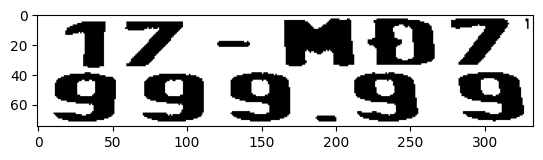

In [17]:

char = segment_characters("output/cropped_plate.jpg")